In [1]:
from fastai.vision.all import *
from fastai import *

In [2]:
path = Path('../input/semi-conductor-image-classification-second-stage/')

In [3]:
path.ls()

(#4) [Path('../input/semi-conductor-image-classification-second-stage/defect_area.csv'),Path('../input/semi-conductor-image-classification-second-stage/train'),Path('../input/semi-conductor-image-classification-second-stage/submission_sample.csv'),Path('../input/semi-conductor-image-classification-second-stage/test')]

In [4]:
f_get = partial(get_image_files,folders='train')

In [5]:
dblocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                    get_items = f_get,
                    splitter = RandomSplitter(seed=42),
                    get_y = parent_label,
                    item_tfms = Resize(224),
                    batch_tfms=[*aug_transforms(max_warp=0.),Normalize.from_stats(*imagenet_stats)]
                   )

In [6]:
dls = dblocks.dataloaders(path,bs=32,num_workers=4)

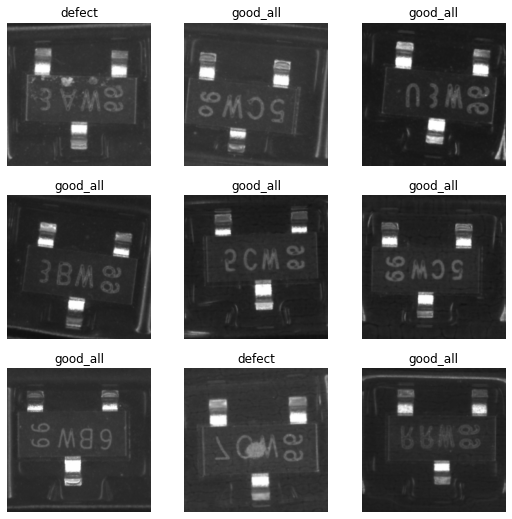

In [7]:
dls.show_batch(max_n=9)

In [8]:
def auc_roc_metrics(preds,targs):
    return RocAucBinary()(preds.argmax(dim=-1),targs)

In [9]:
learn = cnn_learner(dls,resnet50,loss_func=LabelSmoothingCrossEntropy(),metrics=auc_roc_metrics).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=4.365158383734524e-05)

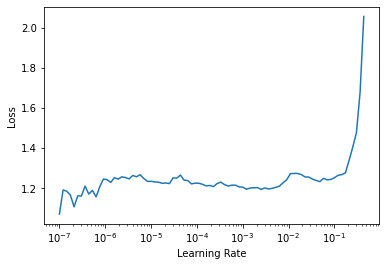

In [10]:
learn.lr_find()

In [11]:
learn.fit_one_cycle(5,1e-3)

epoch,train_loss,valid_loss,auc_roc_metrics,time
0,0.429542,0.340304,0.834230,03:07
1,0.283452,0.255963,0.934001,03:00
2,0.256190,0.235867,0.965543,02:58
3,0.250391,0.229124,0.967607,02:58
4,0.233394,0.227366,0.969995,02:57


SuggestedLRs(lr_min=1.3182566908653825e-05, lr_steep=1.5848931980144698e-06)

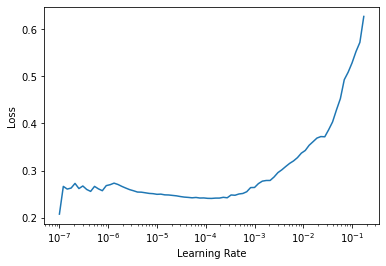

In [12]:
learn.unfreeze()
learn.lr_find()

In [13]:
learn.fit_one_cycle(10,lr_max=(1e-6/2,1e-5/2,1e-4/2))

epoch,train_loss,valid_loss,auc_roc_metrics,time
0,0.241691,0.227340,0.968356,03:42
1,0.237569,0.225868,0.977537,03:42
2,0.239323,0.225601,0.975201,03:40
3,0.231466,0.223543,0.973844,03:42
4,0.229538,0.223040,0.976664,04:18
5,0.233368,0.222875,0.975363,03:40
6,0.223187,0.221545,0.977055,03:41
7,0.225654,0.222001,0.976492,03:41
8,0.223343,0.220727,0.979285,03:41
9,0.219636,0.220806,0.977876,03:42


In [14]:
df_test = pd.read_csv(path/'submission_sample.csv')

In [15]:
def get_test_items(df,path):
    files = [str(path)+'/test/test_contest/test/'+x+'.bmp' for x in df['id']]
    return files

In [16]:
test_dl = dls.test_dl(get_test_items(df_test,path))

In [17]:
preds = learn.get_preds(dl=test_dl)

In [18]:
result = {'id': [], 'defect_score': []}

for fname,score in zip(df_test['id'],preds[0][:,0].tolist()):
    result['id'].append(fname)
    result['defect_score'].append(score)

In [19]:
submission = pd.DataFrame(result)
submission.to_csv('submission.csv', index=False)
submission.head()

,id,defect_score
0,WEP937068H1A_21-5CW-ITISA46-1_254_2,0.041813
1,WEP93700163A_51-APG_ITIS_H13_2_179_1,0.914319
2,WEP937078H4A_38-5CW-ITISA44-1_42_2,0.043538
3,WEA938001H3A_41-5CW-ITISA51-1_40_2,0.037821
4,WEL92208756A_02-U3W-ITISA09-2_165_3,0.041958


In [20]:
#learn.save('/kaggle/working/res50-baseline')

In [21]:
#from IPython.display import FileLinks

In [22]:
#FileLinks('.')